<a href="https://colab.research.google.com/github/tamotamo17/CZII/blob/main/exp047_2_5Dxy3D_backbone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jan 18 00:45:39 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Training base line for [CZII - CryoET Object Identification](https://www.kaggle.com/competitions/czii-cryo-et-object-identification)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!cp /content/drive/MyDrive/ColabNotebooks/CZII/data/czii-dataset-0-6.zip /content
!unzip -q czii-dataset-0-6.zip -d /content
!rm czii-dataset-0-6.zip

!cp /content/drive/MyDrive/ColabNotebooks/CZII/data/czii-cryo-et-object-identification.zip /content
!unzip -q czii-cryo-et-object-identification.zip -d /content
!rm czii-cryo-et-object-identification.zip

CPU times: user 1.43 s, sys: 219 ms, total: 1.65 s
Wall time: 5min 21s


In [ ]:
!pip -q install timm
!pip install -q segmentation_models_pytorch
!pip install natsort cupy-cuda12x==13.3.0
!pip install connected-components-3d

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: cupy-cuda12x
    Found existing installation: cupy-cuda12x 12.2.0
    Uninstalling cupy-cuda12x-12.2.0:
      Successfully uninstalled cupy-cuda12x-12.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 11.4 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/CZII')
import gc
import json
import ast
import cv2
import time
import timm
import pickle
import random
import h5py
from natsort import natsorted
import argparse
import warnings
from itertools import product
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations as A
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp

from src.utils import set_random_seed, color_labeling, convert_to_rgb, convert_to_8bit, create_animation
from src.losses import criterion_seg
from src.metrics import fbeta_score_multiclass, score, coords_from_segmentation_gpu
from src.datasets import CZII2Dto3DDataset, CZII2Dto3DXYZDataset, CZIIScannerDataset
from src.models import Net, encode_for_resnet, MyUnetDecoder3d
from src.trainer import mixup, train_func, valid_func, inf_func

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Config

In [ ]:
class CFG:
    seed = 42
    kernel_type = 'exp047_2.5Dxy3D_backbone'
    load_kernel = None
    load_last = True
    targets2idx = {'apo-ferritin': 1,
                   'beta-amylase': 2,
                   'beta-galactosidase': 3,
                   'ribosome': 4,
                   'thyroglobulin': 5,
                   'virus-like-particle': 6
                   }
    idx2targets = {1: 'apo-ferritin',
                   2: 'beta-amylase',
                   3: 'beta-galactosidase',
                   4: 'ribosome',
                   5: 'thyroglobulin',
                   6: 'virus-like-particle'
                   }
    colors = [[0, 117, 220],
              [153, 63, 0],
              [76, 0, 92],
              [ 0, 92, 49],
              [43, 206, 72],
              [255, 204, 153],
              ]
    samples = ['TS_5_4', 'TS_86_3', 'TS_73_6', 'TS_6_6',
               'TS_69_2', 'TS_99_9', 'TS_6_4'
               ]
    n_folds = 4
    backbone = 'tu-tf_efficientnet_b0.ns_jft_in1k' #"resnet34d"#'tf_efficientnetv2_s_in21ft1k' #"tf_efficientnet_b0.ns_jft_in1k" #

    image_size = 630
    crop_size = 128
    indices_ch = np.arange(-32, 32, 1)#[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    in_chans = len(indices_ch)
    direction = 'xy'

    init_lr = 1e-3#1e-3
    eta_min = 1e-7
    batch_size = 4
    drop_rate = 0.
    drop_rate_last = 0.1
    drop_path_rate = 0.
    p_mixup = 1.0
    p_rand_order_v1 = 0#0.2
    mid_range = 0
    p_drop_plane = 0.0
    alpha = 0.02
    beta = 0.98
    loss_weights = [0.5, 0.5]

    data_dir = '/content/hdf5'
    use_amp = True
    num_workers = 4
    num_targets = len(targets2idx)

    n_epochs = 15
    n_epochs_mixup = n_epochs - 3
    save_root = '/content/drive/MyDrive/ColabNotebooks/CZII/results'
    save_dir = os.path.join(save_root, kernel_type)

    log_dir = os.path.join('logs', save_dir)
    model_dir = os.path.join(save_dir, 'models')
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

In [ ]:
set_random_seed(CFG.seed)

In [ ]:
transforms_train = A.Compose([
    #A.CenterCrop(180, 180, p=1.0),
    #A.RandomBrightness(limit=0.1, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.7),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(CFG.crop_size, CFG.crop_size, p=1.0),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, border_mode=0, p=0.7),

    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
        A.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.2),

    # A.OneOf([
    #     A.OpticalDistortion(distort_limit=1.0),
    #     A.GridDistortion(num_steps=5, distort_limit=1.),
    #     A.ElasticTransform(alpha=3),
    # ], p=0.5),

    #A.Cutout(max_h_size=int(CFG.image_size / 8), max_w_size=int(CFG.image_size /8), num_holes=3, p=0.5),
    #A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)), hole_width_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)))
])

transforms_valid = A.Compose([
    #A.CenterCrop(CFG.crop_size, CFG.crop_size, p=1.0),
    #A.RandomCrop(CFG.crop_size, CFG.crop_size, p=1.0)
])

/usr/local/lib/python3.11/dist-packages/pydantic/main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


# DataFrame

In [ ]:
file_paths = glob('/content/hdf5/*')
data_dicts = {}
df = []
for file_path in file_paths:
    print(file_path)
    base = file_path.split('/')[-1].split('.')[0]
    data = {}
    with h5py.File(file_path, 'r') as f:
        data['image'] = f['image'][:]
        data['label'] = f['label'][:]
    data_dicts[base] = data
    # スライス分のインデックス情報を取得
    num_slices = data['image'].shape[0]

    # データフレーム用のリストに情報を追加
    df_ = []
    for i in range(num_slices):
        df_.append({'sample_name': base, 'slice_index': i})
    df_ = pd.DataFrame(df_)
    df.append(df_)
df = pd.concat(df).reset_index(drop=True)
df['source'] = 'denoised'

/content/hdf5/TS_69_2.h5
/content/hdf5/TS_6_4.h5
/content/hdf5/TS_99_9.h5
/content/hdf5/TS_86_3.h5
/content/hdf5/TS_6_6.h5
/content/hdf5/TS_73_6.h5
/content/hdf5/TS_5_4.h5


In [ ]:
experiment_names = ['TS_5_4', 'TS_86_3', 'TS_73_6', 'TS_6_6',
                    'TS_69_2', 'TS_99_9', 'TS_6_4'
                    ]
target_names = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase',
                'ribosome', 'thyroglobulin', 'virus-like-particle'
                ]

experiments, particle_types = [], []
xs, ys, zs = [], [], []
for experiment_name in experiment_names:
    for target_name in target_names:
        file_path = f'/content/train/overlay/ExperimentRuns/{experiment_name}/Picks/{target_name}.json'
        with open(file_path, 'r') as f:
            data = json.load(f)
        for points in data['points']:
            coords = points['location']
            experiments.append(experiment_name)
            particle_types.append(target_name)
            xs.append(coords['x'])
            ys.append(coords['y'])
            zs.append(coords['z'])
solution = pd.DataFrame({'experiment': experiments,
                          'particle_type': particle_types,
                          'x': xs,
                          'y': ys,
                          'z': zs
                          })
solution


,experiment,particle_type,x,y,z
0,TS_5_4,apo-ferritin,468.514,5915.906,604.167
1,TS_5_4,apo-ferritin,5674.694,1114.354,565.068
2,TS_5_4,apo-ferritin,5744.509,1049.172,653.712
3,TS_5_4,apo-ferritin,5880.769,1125.348,579.560
4,TS_5_4,apo-ferritin,4661.667,1269.497,810.409
...,...,...,...,...,...
1264,TS_6_4,virus-like-particle,5088.704,4120.923,981.513
1265,TS_6_4,virus-like-particle,4268.076,2814.277,815.446
1266,TS_6_4,virus-like-particle,5211.319,5766.513,877.832
1267,TS_6_4,virus-like-particle,4509.570,5139.077,1161.950


# Dataset

In [ ]:
df['fold'] = -1
for fold, sample_name in enumerate(CFG.samples):
    df.loc[df['sample_name']==sample_name, 'fold'] = fold
df

,sample_name,slice_index,source,fold
0,TS_69_2,0,denoised,4
1,TS_69_2,1,denoised,4
2,TS_69_2,2,denoised,4
3,TS_69_2,3,denoised,4
4,TS_69_2,4,denoised,4
...,...,...,...,...
1283,TS_5_4,179,denoised,0
1284,TS_5_4,180,denoised,0
1285,TS_5_4,181,denoised,0
1286,TS_5_4,182,denoised,0


In [ ]:
rcParams['figure.figsize'] = 20,8
df_show = df
dataset_show = CZII2Dto3DDataset(df_show,
                                 data_dicts,
                                 CFG.indices_ch,
                                 CFG.direction,
                                 'train',
                                 transform=transforms_train
                                 )
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)

torch.Size([4, 64, 128, 128]) torch.Size([4, 64, 128, 128])


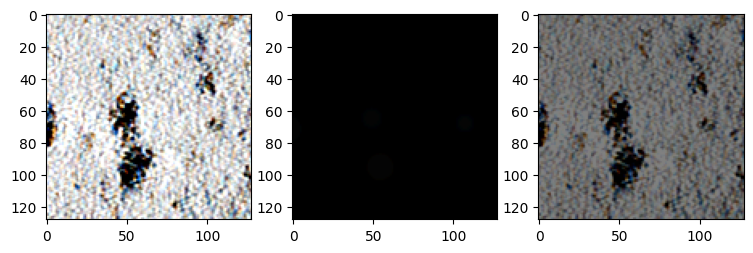

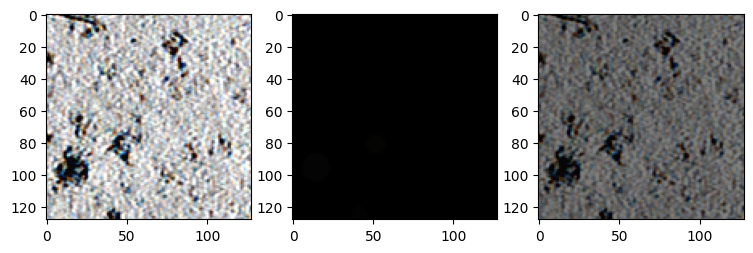

In [ ]:
for data in loader_show:
    imgs = data['image']
    label = data['label']
    for p in range(2):
        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1)
        plt.imshow(imgs[p].permute(1, 2, 0)[...,30:33])
        plt.subplot(1,3,2)
        plt.imshow(label[p].permute(1, 2, 0)[...,30:33])
        plt.subplot(1,3,3)
        plt.imshow(imgs[p].permute(1, 2, 0)[...,30:33])
        plt.imshow(label[p].permute(1, 2, 0)[...,30:33], alpha=0.5)
    break
print(imgs.shape, label.shape)

# Model

In [ ]:
class SegxyModel(nn.Module):
    def __init__(self, backbone, in_chans, out_chans):
        super().__init__()

        self.seg_model_xy = smp.Unet(encoder_name=backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    in_channels=in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                    classes=out_chans,        # model output channels (number of classes in your dataset)
                    activation=None,
                    )
        in_features = self.seg_model_xy.segmentation_head[0].in_channels
        self.segmentation_head = nn.Sequential(nn.Conv3d(in_features, out_chans, kernel_size=5, stride=1, padding=2),
                                               )

    def forward(self, img):
        # yz and zx plane
        img_yz = img.permute(0, 3, 1, 2) # B, D, H, W -> B, W, D, H
        img_zx = img.permute(0, 2, 1, 3) # B, D, H, W -> B, H, D, W

        # xy
        B, D, H, W = img.shape
        img = img.reshape(B*D, 1, H, W)
        encoded_xy = self.seg_model_xy.encoder(img)
        decoded_xy = self.seg_model_xy.decoder(*encoded_xy)
        decoded_xy = decoded_xy.reshape(B, D, -1, H, W) # B, D, C, H, W

        decoded_xy = decoded_xy.permute(0, 2, 1, 3, 4) # B, D, C, H, W -> B, C, D, H, W
        decoded = decoded_xy # torch.cat([decoded_xy, decoded_yz, decoded_zx], dim=1)
        out = self.segmentation_head(decoded)

        return out

In [ ]:
# smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#                     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#                     classes=1,        # model output channels (number of classes in your dataset)
#                     activation=None,
#                     )

In [ ]:
# m = Seg3AxisModelV2(backbone=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#                   in_chans=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#                   out_chans=7,        # model output channels (number of classes in your dataset)
#                   )
# out = m(imgs)
# out.shape

# Train & Valid func

# Training

In [ ]:
def run(fold):
    log_file = os.path.join(CFG.log_dir, f'{CFG.kernel_type}.txt')
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')
    overlap_size = [16,16,16]
    image_shape = [184, 630, 630]
    crop_size = [64, 192, 192]
    radius = [60, 65, 90, 150, 130, 135]
    areas = [400, 450, 500, 2000, 1500, 1500]
    areas = [area*0.4218 for area in areas] # 0.4218 for [184, 630, 630], 0.0527 for[92, 315, 315], 0.09356 for [92, 420, 420]
    areas_max = [area*15 for area in areas]
    resize_size = [184, 630, 630]#[184, 630, 630]
    maxima_filter_sizes = [7, 7, 7, 11, 11, 11]

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CZII2Dto3DDataset(train_,
                                data_dicts,
                                CFG.indices_ch,
                                CFG.direction,
                                'train', transform=transforms_train
                               )
    dataset_valid = CZIIScannerDataset(valid_,
                                       data_dicts,
                                       crop_size=crop_size,
                                       overlap_size=overlap_size,
                                       image_shape=image_shape,
                                       direction=CFG.direction,
                                       mode='valid',
                                       transform=transforms_valid
                                      )
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    model = SegxyModel(backbone=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                  in_chans=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                  out_chans=7,        # model output channels (number of classes in your dataset)
                  )
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=CFG.init_lr)
    scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None

    metric_best = -np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, eta_min=CFG.eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, CFG.n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer,
                                alpha=CFG.alpha, beta=CFG.beta, loss_weights=CFG.loss_weights,
                                p_mixup=CFG.p_mixup, n_epochs_mixup=CFG.n_epochs_mixup,
                                epoch=epoch, device=device, scaler=scaler
                                )
        # valid_score = valid_func_2dto3d(model, dataset_valid,
        #                                 CFG.direction,
        #                                 crop_size=crop_size,
        #                                 size=image_shape,
        #                                 alpha=CFG.alpha, beta=CFG.beta,
        #                                 loss_weights=CFG.loss_weights,
        #                                 solution=solution
        #                                 )
        gt, outputs, valid_loss, valid_loss_ce, valid_loss_tvs = inf_func_2dto3d(model,
                                                                                 dataset_valid,
                                                                                 CFG.direction,
                                                                                 crop_size=crop_size,
                                                                                 size=image_shape
                                                                                 )
        outputs = outputs.argmax(0)
        experiment_name = experiment_names[fold]
        xs_out, ys_out, zs_out = [], [], []
        for i, (target_name, area, area_max, maxima_filter_size) in enumerate(zip(target_names, areas, areas_max, maxima_filter_sizes)):
            size = 4/3*(np.pi*radius[i]*0.02)**3
            outputs_coords_dict = coords_from_segmentation_gpu(outputs,
                                                segmentation_idx=i+1,
                                                maxima_filter_size=maxima_filter_size,#9,
                                                min_particle_size=area,#400,
                                                max_particle_size=area_max,
                                                voxel_spacing_xy=10,#/resize_factor,
                                                voxel_spacing_z=10,
                                                )
            if (i==0):
                if len(outputs_coords_dict)!=0:
                    experiments_out = [experiment_name]*len(outputs_coords_dict)
                    particle_types_out = [target_name]*len(outputs_coords_dict)
                else:
                    experiments_out = []
                    particle_types_out = []
            else:
                if len(outputs_coords_dict)!=0:
                    experiments_out += [experiment_name]*len(outputs_coords_dict)
                    particle_types_out += [target_name]*len(outputs_coords_dict)
            for coords in outputs_coords_dict:
                xs_out.append(coords['x'])
                ys_out.append(coords['y'])
                zs_out.append(coords['z'])
        # break
        submission = pd.DataFrame({'experiment': experiments_out,
                                'particle_type': particle_types_out,
                                'x': xs_out,
                                'y': ys_out,
                                'z': zs_out
                                })

        experiment_names_folds = submission.experiment.unique()
        solution_fold = solution[solution.experiment.isin(experiment_names_folds)].reset_index(drop=True)

        score_ = score(solution=solution_fold.reset_index(),
            submission=submission.reset_index(),
            row_id_column_name='id',
            distance_multiplier=1.0,
            beta=4
            )
        metric = score_

        content = (
            f"{time.ctime()} "
            f"Fold {fold}, "
            f"Epoch {epoch}, "
            f"lr: {optimizer.param_groups[0]['lr']:.7f}, "
            f"train loss: {train_loss:.5f}, \n"
            f"metric: {metric:.6f}, "
            f"valid f4: {score_:.4f}, "
        )

        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict() if scaler else None,
                'score_best': metric_best,
            },
            model_file.replace('_best', '_last')
        )

    del model
    torch.cuda.empty_cache()
    gc.collect()
    return metric_best

def run_inference_2dto3d(fold, transforms_valid, direction, crop_size, raw_size, size, xflip, yflip, zflip):
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')
    overlap_size = (16,16,16)
    image_shape = raw_size
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_valid = CZIIScannerDataset(valid_,
                                       data_dicts,
                                       crop_size=crop_size,
                                       overlap_size=overlap_size,
                                       image_shape=image_shape,
                                       direction=direction,
                                       mode='valid',
                                       transform=transforms_valid
                                      )
    #loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
    model = Seg3AxisModel(backbone=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                  in_chans=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                  out_chans=7,        # model output channels (number of classes in your dataset)
                  )
    if 'last' in model_file:
        model.load_state_dict(torch.load(model_file)['model_state_dict'])
    else:
        model.load_state_dict(torch.load(model_file, weights_only=True))
    model = model.eval().to(device)
    gts, outputs = inf_func_2dto3d(model, dataset_valid, direction, crop_size, size, xflip, yflip, zflip)
    return gts, outputs

def valid_func_2dto3d(model, dataset, direction, crop_size, size,
                      alpha, beta, loss_weights, solution
                      ):
    experiment_names = ['TS_5_4', 'TS_86_3', 'TS_73_6', 'TS_6_6',
                    'TS_69_2', 'TS_99_9', 'TS_6_4'
                    ]
    target_names = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase',
                    'ribosome', 'thyroglobulin', 'virus-like-particle'
                    ]
    radius = [60, 65, 90, 150, 130, 135]
    areas = [400, 450, 500, 2000, 1500, 1500]
    areas = [area*0.4218 for area in areas] # 0.4218 for [184, 630, 630], 0.0527 for[92, 315, 315], 0.09356 for [92, 420, 420]
    areas_max = [area*15 for area in areas]
    resize_size = [184, 630, 630]#[184, 630, 630]
    maxima_filter_sizes = [7, 7, 7, 11, 11, 11]

    model.eval()
    gts = torch.zeros([184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    outputs = torch.zeros([7, 184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    weights = torch.zeros([184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    bar = tqdm(range(len(dataset)))
    with torch.no_grad():
        with torch.amp.autocast('cuda', enabled=True):
            for j in bar:
                data = dataset[j]
                images = data['image'].unsqueeze(0)
                masks = data['label'].unsqueeze(0)
                z = data['z']#.numpy()
                y = data['y']#.numpy()
                x = data['x']#.numpy()
                images = images.to(device)
                masks = masks.to(device)
                logits = model(images)
                logits = logits.squeeze(0)
                masks = masks.squeeze(0)
                if direction=='yz':
                    logits = logits.permute(0,2,3,1)
                    masks = masks.permute(1,2,0)
                elif direction=='zx':
                    logits = logits.permute(0,2,1,3)
                    masks = masks.permute(1,0,2)
                loss, loss_bce, loss_tvs = 0,0,0#criterion_seg(logits, masks)
                outputs[:,z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] += logits
                gts[z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] = masks.to(float)
                weights[z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] += 1
                #break
    #outputs = outputs.permute(1, 0, 2, 3)  # [channels, depth, height, width]
    outputs /= weights
    channels, depth, height, width = outputs.shape
    print(outputs.shape)
    # リサイズのために形状を変更
    #outputs = outputs.reshape(channels * depth, 1, height, width)  # [channels * depth, 1, height, width]
    outputs = F.interpolate(outputs.unsqueeze(0), size=size, mode='trilinear', align_corners=False).squeeze(0)  # [channels * depth, 1, new_height, new_width]
    gts = F.interpolate(gts.unsqueeze(0).unsqueeze(0), size=size, mode='trilinear', align_corners=False).squeeze(0).squeeze(0)
    #gts = gts.to(torch.long)
    print(outputs.shape, gts.shape)
    #loss_seg, loss_bce_seg, loss_tvs_seg = criterion_seg(outputs.unsqueeze(0), gts.unsqueeze(0), alpha, beta, loss_weights)

    outputs = outputs.cpu()
    gts = gts.cpu()
    outputs = outputs.argmax(0)
    experiment_name = experiment_names[fold]
    xs_out, ys_out, zs_out = [], [], []
    for i, (target_name, area, area_max, maxima_filter_size) in enumerate(zip(target_names, areas, areas_max, maxima_filter_sizes)):
        size = 4/3*(np.pi*radius[i]*0.02)**3
        outputs_coords_dict = coords_from_segmentation_gpu(outputs,
                                               segmentation_idx=i+1,
                                               maxima_filter_size=maxima_filter_size,#9,
                                               min_particle_size=area,#400,
                                               max_particle_size=area_max,
                                               voxel_spacing_xy=10,#/resize_factor,
                                               voxel_spacing_z=10,
                                               )
        if (i==0):
            if len(outputs_coords_dict)!=0:
                experiments_out = [experiment_name]*len(outputs_coords_dict)
                particle_types_out = [target_name]*len(outputs_coords_dict)
            else:
                experiments_out = []
                particle_types_out = []
        else:
            if len(outputs_coords_dict)!=0:
                experiments_out += [experiment_name]*len(outputs_coords_dict)
                particle_types_out += [target_name]*len(outputs_coords_dict)
        for coords in outputs_coords_dict:
            xs_out.append(coords['x'])
            ys_out.append(coords['y'])
            zs_out.append(coords['z'])
    # break
    submission = pd.DataFrame({'experiment': experiments_out,
                          'particle_type': particle_types_out,
                          'x': xs_out,
                          'y': ys_out,
                          'z': zs_out
                          })

    experiment_names_folds = submission.experiment.unique()
    solution_fold = solution[solution.experiment.isin(experiment_names_folds)].reset_index(drop=True)

    score_ = score(solution=solution_fold.reset_index(),
        submission=submission.reset_index(),
        row_id_column_name='id',
        distance_multiplier=1.0,
        beta=4
        )
    return score_

def inf_func_2dto3d(model, dataset, direction, crop_size, size, xflip=False, yflip=False, zflip=False):
    model.eval()
    gts = torch.zeros([184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    outputs = torch.zeros([7, 184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    weights = torch.zeros([184, CFG.image_size, CFG.image_size], dtype=torch.float16).to(device)
    bar = tqdm(range(len(dataset)))
    valid_loss, valid_loss_bce, valid_loss_tvs = [], [], []
    with torch.no_grad():
        with torch.amp.autocast('cuda', enabled=True):
            for j in bar:
                cnt = 1
                data = dataset[j]
                images = data['image'].unsqueeze(0)
                masks = data['label'].unsqueeze(0)
                z = data['z']#.numpy()
                y = data['y']#.numpy()
                x = data['x']#.numpy()
                images = images.to(device)
                masks = masks.to(device)
                logits = model(images)
                if xflip:
                    logits_tta = torch.flip(model(torch.flip(images, dims=[3])), dims=[4])
                    logits += logits_tta
                    cnt += 1
                if yflip:
                    logits_tta = torch.flip(model(torch.flip(images, dims=[2])), dims=[3])
                    logits += logits_tta
                    cnt += 1
                if zflip:
                    logits_tta = torch.flip(model(torch.flip(images, dims=[1])), dims=[2])
                    logits += logits_tta
                    cnt += 1
                logits /= cnt
                logits = logits.squeeze(0)
                masks = masks.squeeze(0)
                if direction=='yz':
                    logits = logits.permute(0,2,3,1)
                    masks = masks.permute(1,2,0)
                elif direction=='zx':
                    logits = logits.permute(0,2,1,3)
                    masks = masks.permute(1,0,2)
                loss, loss_bce, loss_tvs = criterion_seg(logits.unsqueeze(0), masks.unsqueeze(0), CFG.alpha, CFG.beta, CFG.loss_weights)
                valid_loss.append(loss.item())
                valid_loss_bce.append(loss_bce.item())
                valid_loss_tvs.append(loss_tvs.item())
                outputs[:,z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] += logits
                gts[z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] = masks#.to(dtype=torch.long)
                weights[z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]] += 1
    #outputs = outputs.permute(1, 0, 2, 3)  # [channels, depth, height, width]
    outputs /= weights
    channels, depth, height, width = outputs.shape
    # リサイズのために形状を変更
    #outputs = outputs.reshape(channels * depth, 1, height, width)  # [channels * depth, 1, height, width]
    outputs = F.interpolate(outputs.unsqueeze(0), size=size, mode='trilinear', align_corners=False).squeeze(0)  # [channels * depth, 1, new_height, new_width]
    gts = F.interpolate(gts.unsqueeze(0).unsqueeze(0), size=size, mode='trilinear', align_corners=False).squeeze(0).squeeze(0)
    outputs = outputs.cpu()
    gts = gts.cpu()
    return gts, outputs, np.mean(valid_loss), np.mean(valid_loss_bce), np.mean(valid_loss_tvs)

In [ ]:
RUN_TRAIN = True
if RUN_TRAIN:
    folds = [0, 1, 2]
    best_scores = []
    for i in folds:
        best_score = run(i)
        best_scores.append(best_score)
    print(best_scores)
    print(np.mean(best_scores))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

<ipython-input-18-7889637f5daa>:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 64
Sat Jan 18 00:52:28 2025 Epoch: 1


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:12<00:00,  5.22it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
Sat Jan 18 00:57:18 2025 Fold 0, Epoch 1, lr: 0.0010000, train loss: 0.31684, 
metric: 0.254407, valid f4: 0.2544, 
metric_best (-inf --> 0.254407). Saving model ...
Sat Jan 18 00:57:18 2025 Epoch: 2


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.78it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
Sat Jan 18 01:01:45 2025 Fold 0, Epoch 2, lr: 0.0009891, train loss: 0.23438, 
metric: 0.528312, valid f4: 0.5283, 
metric_best (0.254407 --> 0.528312). Saving model ...
Sat Jan 18 01:01:45 2025 Epoch: 3


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.80it/s]


No segmentation with label 2 found.
Sat Jan 18 01:06:14 2025 Fold 0, Epoch 3, lr: 0.0009568, train loss: 0.19977, 
metric: 0.583629, valid f4: 0.5836, 
metric_best (0.528312 --> 0.583629). Saving model ...
Sat Jan 18 01:06:14 2025 Epoch: 4


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.71it/s]


No segmentation with label 2 found.
Sat Jan 18 01:10:43 2025 Fold 0, Epoch 4, lr: 0.0009045, train loss: 0.18600, 
metric: 0.668322, valid f4: 0.6683, 
metric_best (0.583629 --> 0.668322). Saving model ...
Sat Jan 18 01:10:44 2025 Epoch: 5


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.76it/s]


No segmentation with label 2 found.
Sat Jan 18 01:15:14 2025 Fold 0, Epoch 5, lr: 0.0008346, train loss: 0.18233, 
metric: 0.729618, valid f4: 0.7296, 
metric_best (0.668322 --> 0.729618). Saving model ...
Sat Jan 18 01:15:14 2025 Epoch: 6


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.74it/s]


No segmentation with label 2 found.
Sat Jan 18 01:19:43 2025 Fold 0, Epoch 6, lr: 0.0007500, train loss: 0.17216, 
metric: 0.737453, valid f4: 0.7375, 
metric_best (0.729618 --> 0.737453). Saving model ...
Sat Jan 18 01:19:44 2025 Epoch: 7


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.78it/s]


No segmentation with label 2 found.
Sat Jan 18 01:24:14 2025 Fold 0, Epoch 7, lr: 0.0006545, train loss: 0.17045, 
metric: 0.687805, valid f4: 0.6878, 
Sat Jan 18 01:24:14 2025 Epoch: 8


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.76it/s]


No segmentation with label 2 found.
Sat Jan 18 01:28:42 2025 Fold 0, Epoch 8, lr: 0.0005523, train loss: 0.16291, 
metric: 0.718357, valid f4: 0.7184, 
Sat Jan 18 01:28:42 2025 Epoch: 9


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.78it/s]


No segmentation with label 2 found.
Sat Jan 18 01:33:10 2025 Fold 0, Epoch 9, lr: 0.0004478, train loss: 0.16464, 
metric: 0.741691, valid f4: 0.7417, 
metric_best (0.737453 --> 0.741691). Saving model ...
Sat Jan 18 01:33:10 2025 Epoch: 10


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.72it/s]


No segmentation with label 2 found.
Sat Jan 18 01:37:36 2025 Fold 0, Epoch 10, lr: 0.0003456, train loss: 0.15805, 
metric: 0.713591, valid f4: 0.7136, 
Sat Jan 18 01:37:36 2025 Epoch: 11


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.83it/s]


No segmentation with label 2 found.
Sat Jan 18 01:42:04 2025 Fold 0, Epoch 11, lr: 0.0002501, train loss: 0.15508, 
metric: 0.723132, valid f4: 0.7231, 
Sat Jan 18 01:42:04 2025 Epoch: 12


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.70it/s]


No segmentation with label 2 found.
Sat Jan 18 01:46:32 2025 Fold 0, Epoch 12, lr: 0.0001655, train loss: 0.11703, 
metric: 0.757873, valid f4: 0.7579, 
metric_best (0.741691 --> 0.757873). Saving model ...
Sat Jan 18 01:46:33 2025 Epoch: 13


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.75it/s]


No segmentation with label 2 found.
Sat Jan 18 01:50:58 2025 Fold 0, Epoch 13, lr: 0.0000956, train loss: 0.11289, 
metric: 0.759221, valid f4: 0.7592, 
metric_best (0.757873 --> 0.759221). Saving model ...
Sat Jan 18 01:50:59 2025 Epoch: 14


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.75it/s]


No segmentation with label 2 found.
Sat Jan 18 01:55:26 2025 Fold 0, Epoch 14, lr: 0.0000433, train loss: 0.10696, 
metric: 0.761055, valid f4: 0.7611, 
metric_best (0.759221 --> 0.761055). Saving model ...
Sat Jan 18 01:55:27 2025 Epoch: 15


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.76it/s]


No segmentation with label 2 found.
Sat Jan 18 01:59:55 2025 Fold 0, Epoch 15, lr: 0.0000110, train loss: 0.11119, 
metric: 0.792282, valid f4: 0.7923, 
metric_best (0.761055 --> 0.792282). Saving model ...


<ipython-input-18-7889637f5daa>:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 64
Sat Jan 18 01:59:56 2025 Epoch: 1


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.78it/s]


No segmentation with label 2 found.
Sat Jan 18 02:04:23 2025 Fold 1, Epoch 1, lr: 0.0010000, train loss: 0.31431, 
metric: 0.282768, valid f4: 0.2828, 
metric_best (-inf --> 0.282768). Saving model ...
Sat Jan 18 02:04:24 2025 Epoch: 2


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.78it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
Sat Jan 18 02:08:46 2025 Fold 1, Epoch 2, lr: 0.0009891, train loss: 0.23947, 
metric: 0.546945, valid f4: 0.5469, 
metric_best (0.282768 --> 0.546945). Saving model ...
Sat Jan 18 02:08:46 2025 Epoch: 3


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.87it/s]


No segmentation with label 2 found.
Sat Jan 18 02:13:13 2025 Fold 1, Epoch 3, lr: 0.0009568, train loss: 0.19124, 
metric: 0.606446, valid f4: 0.6064, 
metric_best (0.546945 --> 0.606446). Saving model ...
Sat Jan 18 02:13:13 2025 Epoch: 4


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.85it/s]


No segmentation with label 2 found.
Sat Jan 18 02:17:40 2025 Fold 1, Epoch 4, lr: 0.0009045, train loss: 0.18314, 
metric: 0.624177, valid f4: 0.6242, 
metric_best (0.606446 --> 0.624177). Saving model ...
Sat Jan 18 02:17:40 2025 Epoch: 5


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 64/64 [00:09<00:00,  6.86it/s]


No segmentation with label 2 found.
Sat Jan 18 02:22:06 2025 Fold 1, Epoch 5, lr: 0.0008346, train loss: 0.18219, 
metric: 0.735336, valid f4: 0.7353, 
metric_best (0.624177 --> 0.735336). Saving model ...
Sat Jan 18 02:22:06 2025 Epoch: 6


  0%|          | 0/276 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
smth:0.1649:  85%|████████▍ | 234/276 [03:09<00:34,  1.23it/s]


KeyboardInterrupt: 

In [ ]:
RUN_TRAIN = True
if RUN_TRAIN:
    folds = [3, 4, 5, 6]
    best_scores = []
    for i in folds:
        best_score = run(i)
        best_scores.append(best_score)
    print(best_scores)
    print(np.mean(best_scores))

In [ ]:
best_scores

[0.6615002981036266,
 0.7071601121882781,
 0.6694452520104981,
 0.6781532016880413]

In [ ]:
gts, outputs = run_inference(0)
outputs = outputs.argmax(1)

<ipython-input-25-c8d0212bde6d>:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))
smth:0.0950: 100%|██████████| 12/12 [00:09<0

In [ ]:
nslice = 5
offset = 5
idx_start = 10
# img = convert_to_rgb(convert_to_8bit(data_dicts[sample_id]['image'], 3, 99))
gts_c = color_labeling(gts)
outputs_c = color_labeling(outputs)
space = np.ones([len(gts_c), CFG.image_size, 10, 3], dtype=np.uint8)*255
concat = np.concatenate([gts_c, space, outputs_c], axis=2)
# plt.figure(figsize=(12,4))
# for i in range(nslice):
#     plt.subplot(2, nslice, i+1)
#     plt.imshow(gts[i*offset+idx_start])
#     plt.subplot(2, nslice, i+1+nslice)
    # plt.imshow(outputs_c[i*offset+idx_start])

create_animation(concat)

In [ ]:
transforms_valid_2dto3d = A.Compose([
    #A.CenterCrop(180, 180, p=1.0),
    # A.Resize(CFG.image_size, CFG.image_size),
    # A.RandomCrop(CFG.crop_size, CFG.crop_size, p=1.0)
])

In [ ]:
%%time


radius = [60, 65, 90, 150, 130, 135]
areas = [400, 450, 500, 2000, 1500, 1500]
areas = [area*0.4218 for area in areas] # 0.4218 for [184, 630, 630], 0.0527 for[92, 315, 315], 0.09356 for [92, 420, 420]
areas_max = [area*15 for area in areas]
resize_size = [184, 630, 630]#[184, 630, 630]
maxima_filter_sizes = [7, 7, 7, 11, 11, 11]
xflip = False
yflip = False
zflip = False
xs_gt, ys_gt, zs_gt = [], [], []
xs_out, ys_out, zs_out = [], [], []
path_results = '/kaggle/input/czii-models/'
for fold in [0]:
    crop_size = (64, 192, 192)
    gts, outputs_2dto3d_xy = run_inference_2dto3d(fold,
                                               transforms_valid=transforms_valid,
                                               direction='xy',
                                               crop_size=crop_size,
                                               raw_size=resize_size,
                                               size=resize_size,
                                               xflip=xflip,
                                               yflip=yflip,
                                               zflip=zflip
                                              )

    outputs = outputs_2dto3d_xy
    outputs = outputs.argmax(0)
    experiment_name = experiment_names[fold]
    for i, (target_name, area, area_max, maxima_filter_size) in enumerate(zip(target_names, areas, areas_max, maxima_filter_sizes)):
        size = 4/3*(np.pi*radius[i]*0.02)**3
        outputs_coords_dict = coords_from_segmentation_gpu(outputs,
                                               segmentation_idx=i+1,
                                               maxima_filter_size=maxima_filter_size,#9,
                                               min_particle_size=area,#400,
                                               max_particle_size=area_max,
                                               voxel_spacing_xy=10,#/resize_factor,
                                               voxel_spacing_z=10,
                                               )
        if (i==0)&(fold==0):
            if len(outputs_coords_dict)!=0:
                experiments_out = [experiment_name]*len(outputs_coords_dict)
                particle_types_out = [target_name]*len(outputs_coords_dict)
            else:
                experiments_out = []
                particle_types_out = []
        else:
            if len(outputs_coords_dict)!=0:
                experiments_out += [experiment_name]*len(outputs_coords_dict)
                particle_types_out += [target_name]*len(outputs_coords_dict)
        for coords in outputs_coords_dict:
            xs_out.append(coords['x'])
            ys_out.append(coords['y'])
            zs_out.append(coords['z'])
    # break
submission = pd.DataFrame({'experiment': experiments_out,
                          'particle_type': particle_types_out,
                          'x': xs_out,
                          'y': ys_out,
                          'z': zs_out
                          })

experiment_names_folds = submission.experiment.unique()
solution_fold = solution[solution.experiment.isin(experiment_names_folds)].reset_index(drop=True)

score_ = score(solution=solution_fold.reset_index(),
    submission=submission.reset_index(),
    row_id_column_name='id',
    distance_multiplier=1.0,
    beta=4
    )
print(score_)
scores = []
for experiment_name in experiment_names:
    score_ = score(solution=solution[solution.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  submission=submission[submission.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  row_id_column_name='id',
                  distance_multiplier=1.0,
                  beta=4
                  )
    scores.append(score_)
    print(experiment_name, score_)

100%|██████████| 64/64 [00:11<00:00,  5.39it/s]


No segmentation with label 2 found.
No segmentation with label 3 found.
0.5616964759579143
TS_5_4 0.5616964759579143
TS_86_3 0.0
TS_73_6 0.0
TS_6_6 0.0
TS_69_2 0.0
TS_99_9 0.0
TS_6_4 0.0
CPU times: user 1min 15s, sys: 6.79 s, total: 1min 22s
Wall time: 44.3 s


In [ ]:
submission = pd.DataFrame({'experiment': experiments_out,
                          'particle_type': particle_types_out,
                          'x': xs_out,
                          'y': ys_out,
                          'z': zs_out
                          })

In [ ]:
experiment_names_folds = submission.experiment.unique()
solution_fold = solution[solution.experiment.isin(experiment_names_folds)].reset_index(drop=True)

In [ ]:
len(submission), len(solution)

(2721, 1269)

In [ ]:
score_ = score(solution=solution_fold.reset_index(),
    submission=submission.reset_index(),
    row_id_column_name='id',
    distance_multiplier=1.0,
    beta=4
    )
print(score_)
scores = []
for experiment_name in experiment_names:
    score_ = score(solution=solution[solution.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  submission=submission[submission.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  row_id_column_name='id',
                  distance_multiplier=1.0,
                  beta=4
                  )
    scores.append(score_)
    print(experiment_name, score_)

0.8194031885369933
TS_5_4 0.7958637353002892
TS_86_3 0.8499739478751754
TS_73_6 0.8319453780266607
TS_6_6 0.8175983755883844
TS_69_2 0.856850803235851
TS_99_9 0.7955788964076402
TS_6_4 0.7727427348743063


In [ ]:
scores

[0.812545167836226,
 0.860706494640679,
 0.8035907103965083,
 0.804193336460791,
 0.849920729998023,
 0.7993035810382877,
 0.798601442600552]